In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import openpyxl
import os
os.makedirs('out', exist_ok=True)

# Kapitel: Datenfilterfunktionen

Daten von CSV in Data Frame extrahieren

In [2]:
def load_csv_as_data_x(file_path):
    """
    Lädt eine CSV-Datei und gibt sie als DataFrame zurück.
    Die relevanten Spaltennamen werden generalisiert:
      - 'plannedArrival' oder 'plannedDeparture' -> 'planned'
      - 'changedArrivalTime' oder 'changedDepartureTime' -> 'changed'
      - 'arrival_delay' oder 'departure_delay' -> 'delay'
    Zusätzlich werden alle negativen 'delay'-Werte auf 0 gesetzt.

    :param file_path: Der Pfad zur CSV-Datei, die geladen werden soll.
    :return: DataFrame mit generalisierten Spaltennamen und angepassten Werten.
    """
    try:
        # CSV-Datei einlesen, unter der Annahme, dass die Spalten durch Semikolon getrennt sind
        df = pd.read_csv(file_path, sep=";", header=0)
        
        # Spaltenumbenennung basierend auf gemeinsamer Bedeutung
        rename_mapping = {
            'plannedArrival': 'planned',
            'plannedDeparture': 'planned',
            'changedArrivalTime': 'changed',
            'changedDepartureTime': 'changed',
            'arrival_delay': 'delay',
            'departure_delay': 'delay'
        }
        
        # Nur Spalten umbenennen, die tatsächlich in der CSV vorhanden sind
        df.rename(columns={col: rename_mapping[col] for col in df.columns if col in rename_mapping}, inplace=True)
        
        # Falls die generalisierte Spalte 'delay' existiert, negative Werte auf 0 setzen
        if 'delay' in df.columns:
            df['delay'] = df['delay'].apply(lambda x: max(x, 0))
    
    except FileNotFoundError:
        raise ValueError(f"Die Datei unter dem Pfad {file_path} wurde nicht gefunden.")
    except pd.errors.EmptyDataError:
        raise ValueError("Die CSV-Datei ist leer.")
    except Exception as e:
        raise ValueError(f"Fehler beim Einlesen der Datei: {e}")
    
    return df


Filtert die Daten entsprechend auf Wunsch nach Bahnhof, Datum oder Woche

In [3]:
def filter_data_x(data, evas=None, date=None, week_number=None):
    """
    Filtert die Daten basierend auf den gegebenen Parametern.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param evas: Liste von EVA-Nummern der Bahnhöfe, nach denen gefiltert werden soll (Optional).
    :param date: Das Datum, nach dem gefiltert werden soll (Optional, im Format 'YYYY-MM-DD').
    :param week_number: Die Kalenderwoche, nach der gefiltert werden soll (Optional).
    :return: Gefilterte Daten, die an die jeweilige Berechnungsfunktion übergeben werden können.
    """
    
    # Überprüfen, ob die Daten vorhanden sind
    if data.empty:
        print("Es sind keine Daten vorhanden.")
        return None
    
    # Stelle sicher, dass die EVA-Spalte als String behandelt wird
    data['eva'] = data['eva'].astype(str)
    
    # Wenn evas nicht spezifiziert, berücksichtige alle
    if evas is not None:
        # Falls nur ein einzelner Wert übergeben wurde, konvertiere ihn in eine Liste
        if isinstance(evas, str):
            evas = [evas]
        
        # Falls die übergebenen EVAs nicht in den Daten sind, gib eine Warnung aus
        if not set(evas).issubset(data['eva'].values):
            print(f"Es gibt keine Bahnhöfe mit den EVA-Nummern {evas}.")
            return None
        # Filtere nach den angegebenen EVA-Nummern
        data = data[data['eva'].isin(evas)]
    
    # Wenn ein Datum angegeben ist, nach Jahr, Monat und Tag filtern
    if date:
        data['date'] = pd.to_datetime(data['planned']).dt.date
        data = data[data['date'] == pd.to_datetime(date).date()]
    
    # Wenn eine Kalenderwoche angegeben ist, nach dieser filtern
    if week_number:
        if date:
            print("Tag und Kalenderwoche können nicht gleichzeitig ausgewählt werden.")
            return None
        data['week_number'] = pd.to_datetime(data['planned']).dt.isocalendar().week
        data = data[data['week_number'] == week_number]
    
    return data


# Kapitel: Visualisierungsfunktionen

Erstellt den Balken Graph zu den Daten

In [4]:
def plot_bar_chart_by_category_and_station_x(data, x_column='X', y_column='Y', 
                                           hue_column='station', title='', 
                                           x_axis_label='Zugkategorie', y_axis_label='Verspätungsprozentsatz', 
                                           palette='Set2', y_limit_factor=1.1, text_offset_factor=0.03, 
                                           show_values=True, fig_size_x=17, fig_size_y=8, int_value=True):
    """
    Erstellt ein Balkendiagramm, das für jede Zugart (x-Achse) Balken für jeden Bahnhof oder Kalenderwoche anzeigt.
    
    :param data: DataFrame mit den Daten für das Diagramm.
    :param x_column: Name der Spalte für die x-Achse (z. B. Zugkategorien).
    :param y_column: Name der Spalte für die y-Achse (z. B. Verspätungsprozentsatz).
    :param hue_column: Name der Spalte für die Farbcodierung (z. B. Bahnhöfe oder Kalenderwoche).
    :param title: Titel des Diagramms.
    :param x_axis_label: Bezeichnung der x-Achse.
    :param y_axis_label: Bezeichnung der y-Achse.
    :param palette: Farbpalette für die Balken (Standard: 'Set2').
    :param y_limit_factor: Faktor für die Y-Achsen-Limit (Standard: 1.1).
    :param text_offset_factor: Faktor zur Berechnung des Abstands für die Textanzeige (Standard: 0.03).
    :param show_values: Boolean, ob die Werte über den Balken angezeigt werden sollen (Standard: True).
    :param int_value: Boolean, ob die Zahlen über den Balken als int oder double angezeigt werden (Standardwert: True)
    """
    
    # Überprüfen, ob die Spalte "week_number" existiert, um den Namen der Legende anzupassen
    if 'week_number' in data.columns:
        hue_column = 'week_number'  # Ändere die Spalte für die Farbcodierung
        legend_title = 'Kalenderwoche'  # Setze den Legendentitel
    else:
        legend_title = 'Bahnhof'  # Standardwert, falls es keine "week_number"-Spalte gibt
    
    # Maximalwert für die Y-Achse berechnen
    y_limit = data[y_column].max() * y_limit_factor

    # Abstand für die Zahl über den Balken berechnen
    text_offset_max_factor = data[y_column].max() * text_offset_factor 
    
    # Balkendiagramm erstellen
    plt.figure(figsize=(fig_size_x, fig_size_y))
    ax = sns.barplot(x=x_column, y=y_column, hue=hue_column, data=data, palette=palette)
    
    # Titel und Achsenbeschriftungen setzen
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    # Werte über den Balken anzeigen
    if show_values:
        for bar in ax.patches:
            yval = bar.get_height()
            if yval > 0:  # Nur Werte > 0 anzeigen
                if int_value:
                    yval = int(yval)  # Ganze Zahl, wenn int_value True
                else:
                    yval = round(yval, 1)  # Eine Nachkommastelle, wenn int_value False

                plt.text(
                    bar.get_x() + bar.get_width() / 2, 
                    yval + text_offset_max_factor, 
                    f"{yval}",  # Anzeige des Werts
                    ha='center', 
                    va='bottom'
                )

    # Y-Achse anpassen
    plt.ylim(0, y_limit)
    
    # Legende anpassen
    plt.legend(title=legend_title)
    plt.tight_layout()
    plt.show()


Erstellt einen Liniengraph zu den Zuglinien

In [5]:
def plot_line_chart(data, title='', xlabel='', ylabel='', xsize=10, ysize=6):
    """
    Erstellt einen Liniengraphen für die Daten und stellt sicher, dass die X-Achse
    korrekt skaliert wird, abhängig davon, ob 'day_of_week' oder 'week_number' verwendet wird.

    :param data: DataFrame mit Spalten 'X', 'day_of_week'/'week_number', und 'Y'.
    :param title: Titel des Graphen.
    :param xlabel: Beschriftung der X-Achse.
    :param ylabel: Beschriftung der Y-Achse.
    """
    if data is None or data.empty:
        print("Keine Daten zum Plotten verfügbar.")
        return

    plt.figure(figsize=(xsize, ysize))

    # X-Achse bestimmen
    if "day_of_week" in data.columns:
        x_column = "day_of_week"
        x_ticks = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        # Umwandlung in numerische Werte für die Reihenfolge
        weekdays_order = {day: i for i, day in enumerate(x_ticks)}
        data["x_value"] = data[x_column].map(weekdays_order)
    elif "week_number" in data.columns:
        x_column = "week_number"
        x_ticks = sorted(data[x_column].unique())  # Alle Kalenderwochen als numerische Werte
        data["x_value"] = data[x_column]
    else:
        print("Keine gültige Spalte für die X-Achse gefunden.")
        return

    # Linien für jede Station erstellen
    for station, group in data.groupby("X"):
        plt.plot(group["x_value"], group["Y"], label=station, marker='o')
        # Werte über den Punkten anzeigen
        for x, y in zip(group["x_value"], group["Y"]):
            plt.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

    # Plot-Details
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel if xlabel else x_column, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Anpassung der X-Ticks
    if x_column == "day_of_week":
        plt.xticks(ticks=range(len(x_ticks)), labels=x_ticks, rotation=45)
    elif x_column == "week_number":
        plt.xticks(ticks=x_ticks, labels=x_ticks)

    plt.grid(visible=True, linestyle="--", alpha=0.7)
    plt.legend(title="Station", fontsize=10, title_fontsize=12)

    # Plot anzeigen
    plt.show()

# Kapitel: Datenaufbereitung entsprechend der Forschungsfragen

Berechnet je Zugart wie viel Prozent der Züge verpätet sind. Bezieht nur Züge mit ein, deren Verstpätung höher als `delay_threshold`sind.

In [6]:
def calculate_percentage_delay_by_category_and_station_x(
    data, delay_threshold=0, categories=None, combine_all_categories=False
):
    """
    Berechnet den Prozentsatz der verspäteten Züge je Zugart und je Bahnhof sowie einen Durchschnittsbalken.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param delay_threshold: Schwellenwert für die Verspätung in Minuten.
    :param categories: Optional, Liste spezifischer Zugarten zum Filtern (z. B. ['ICE', 'RE']).
    :param combine_all_categories: Boolean, ob alle Zugarten zusammen betrachtet werden sollen. Standard: False.
    :return: DataFrame mit den Spalten: X (Zugkategorie), Y (Verspätungsprozentsatz) und station (Bahnhof).
    """
    if combine_all_categories:
        # Alle Zugarten zusammen betrachten (trainCategory ignorieren)
        delayed_trains = data[data['delay'] > delay_threshold]
        total_trains = data.groupby(['station']).size()
        delayed_trains_by_category = delayed_trains.groupby(['station']).size()
        
        # Prozentsatz der verspäteten Züge je Bahnhof
        percentage_delay = (delayed_trains_by_category / total_trains) * 100
        
        # DataFrame mit den Ergebnissen
        result = percentage_delay.reset_index(name='delayPercentage')
        
        # Spalte 'X' für Zugkategorie setzen (als "Alle")
        result['X'] = 'Alle'
    else:
        # Optional nach spezifischen Zugarten filtern
        if categories:
            data = data[data['trainCategory'].isin(categories)]
        
        # Züge filtern, die mehr als 'delay_threshold' Minuten Verspätung haben
        delayed_trains = data[data['delay'] > delay_threshold]
        
        # Zugarten getrennt betrachten (falls keine spezifische Kategorie gefiltert wurde)
        total_trains = data.groupby(['trainCategory', 'station']).size()
        delayed_trains_by_category = delayed_trains.groupby(['trainCategory', 'station']).size()
        
        # Prozentsatz der verspäteten Züge je Zugkategorie und Bahnhof
        percentage_delay = (delayed_trains_by_category / total_trains) * 100
        
        # DataFrame mit den Ergebnissen
        result = percentage_delay.reset_index(name='delayPercentage')
        
        # Umbenennen der Spalten für das gewünschte Format
        result = result.rename(columns={'trainCategory': 'X'})
    
    # Umbenennen der Spalte für den Prozentsatz
    result = result.rename(columns={'delayPercentage': 'Y'})
    
    # NaN-Werte durch 0 ersetzen und auf 2 Dezimalstellen runden
    result['Y'] = result['Y'].fillna(0).apply(lambda x: int(x * 100) / 100)
    
    return result


Berechnet die durchschnittliche Verspätung je Zugart in Minuten. Bezieht nur Züge mit ein, deren Verspätung höher als `delay_threshold` sind

In [7]:
def calculate_average_min_delay_by_category_and_station_x(
    data, delay_threshold=0, categories=None, combine_all_categories=False
):
    """
    Berechnet die durchschnittliche Verspätung in Minuten pro Zugart und Bahnhof.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param delay_threshold: Minimaler Schwellenwert für die Verspätung (in Minuten), um in die Berechnung einbezogen zu werden.
    :param categories: Optional, Liste spezifischer Zugarten zum Filtern (z. B. ['ICE', 'RE']).
    :param combine_all_categories: Boolean, ob alle Zugarten zusammen betrachtet werden sollen. Standard: False.
    :return: DataFrame mit den Spalten 'X' (Zugart), 'Y' (Durchschnittliche Verspätung in Minuten) und 'station' (Bahnhof).
    """
    if data.empty:
        print("Keine Daten für die Berechnung der Verspätung vorhanden.")
        return None

    # Nur Züge mit einer Verspätung größer als der Schwellenwert berücksichtigen
    delayed_data = data[data['delay'] > delay_threshold]
    
    if delayed_data.empty:
        print(f"Keine Züge mit einer Verspätung größer als {delay_threshold} Minuten gefunden.")
        return None
    
    if combine_all_categories:
        # Alle Zugarten zusammen betrachten (trainCategory ignorieren)
        avg_delay_by_station = delayed_data.groupby(['station'])['delay'].mean().reset_index()
        
        # Spalte 'X' für Zugkategorie setzen (als "Alle")
        avg_delay_by_station['X'] = 'Alle'
        
        # Umbenennen der Spalten für das gewünschte Format
        result = avg_delay_by_station.rename(columns={'delay': 'Y'})
    else:
        # Optional nach spezifischen Zugarten filtern
        if categories:
            delayed_data = delayed_data[delayed_data['trainCategory'].isin(categories)]
        
        # Durchschnittliche Verspätung pro Zugart und Bahnhof berechnen
        avg_delay_by_category_station = delayed_data.groupby(['trainCategory', 'station'])['delay'].mean().reset_index()
        
        # Ergebnis formatieren
        avg_delay_by_category_station['X'] = avg_delay_by_category_station['trainCategory']
        avg_delay_by_category_station = avg_delay_by_category_station[['X', 'station', 'delay']]
        
        # Umbenennen der Spalten für das gewünschte Format
        result = avg_delay_by_category_station.rename(columns={'delay': 'Y'})
    
    # Runden der durchschnittlichen Verspätung auf 1 Dezimalstelle
    result['Y'] = result['Y'].round(1)
    
    return result


Berechnet wie viel Prozent der Verspäteten Züge in eine Bestimmte Verspätungskategorie fallen.

In [8]:
def calculate_delay_statistics_by_train_type_and_station_x(data, train_type=None):
    """
    Berechnet die Statistik der Verspätungen für bestimmte Zugarten oder für alle Züge,
    wenn keine Zugart angegeben ist, aus einem bereits gefilterten DataFrame.
    
    :param data: DataFrame, das die bereits gefilterten Daten enthält.
    :param train_type: Liste von Zugarten, für die die Statistik berechnet werden soll. 
                       Wenn None, wird für alle Zugarten berechnet.
    :return: DataFrame mit den Verspätungskategorien (X) und deren prozentualem Anteil (Y) sowie der Stationen-Spalte.
    """
    # Wenn Zugarten angegeben sind, nur diese berücksichtigen
    if train_type:
        data = data[data['trainCategory'].isin(train_type)]
    
    # Überprüfen, ob es nach der Filterung noch Daten gibt
    if data.empty:
        print(f"Keine Daten für die Zugart '{train_type}' gefunden." if train_type else "Keine Daten gefunden.")
        return None
    
    # Filtere auf Züge mit einer positiven Verspätung
    df_delayed = data[data['delay'] > 0]
    
    # Überprüfen, ob es verspätete Züge gibt
    if df_delayed.empty:
        print(f"Es gibt keine verspäteten Züge.")
        return None

    # Gesamtanzahl der verspäteten Züge
    total_delays = len(df_delayed)
    
    # Berechnung des prozentualen Anteils in jeder Kategorie und nach Station
    delay_stats = []
    for station in df_delayed['station'].unique():  # Gruppiert nach Station
        station_data = df_delayed[df_delayed['station'] == station]
        
        stats = {
            'station': station,
            '< 10 min': (station_data['delay'] < 10).sum() / len(station_data) * 100,
            '< 30 min': ((station_data['delay'] >= 10) & (station_data['delay'] < 30)).sum() / len(station_data) * 100,
            '< 60 min': ((station_data['delay'] >= 30) & (station_data['delay'] < 60)).sum() / len(station_data) * 100,
            '< 120 min': ((station_data['delay'] >= 60) & (station_data['delay'] < 120)).sum() / len(station_data) * 100,
            '> 120 min': (station_data['delay'] >= 120).sum() / len(station_data) * 100
        }
        delay_stats.append(stats)

    # Umwandlung der Statistik in einen DataFrame
    stats_df = pd.DataFrame(delay_stats)
    
    # Reshape für die Darstellung der Kategorien in der Spalte 'X'
    stats_df = pd.melt(stats_df, id_vars=['station'], var_name='X', value_name='Y')

    # Optional: Y-Werte runden
    stats_df['Y'] = stats_df['Y'].apply(lambda x: round(x, 1))

    return stats_df


In [9]:
def calculate_delay_by_line_and_day(data, line='', output_type="%", delay_threshold=0):
    """
    Berechnet den Prozentsatz oder die durchschnittliche Verspätung einer bestimmten Zuglinie je Wochentag und Bahnhof.
    """
    if data.empty:
        print("Keine Daten verfügbar.")
        return None

    # Nach der gewünschten Linie filtern
    filtered_data = data[data["Verbindung"] == line].copy()
    if filtered_data.empty:
        print(f"Keine Daten für die Linie {line} gefunden.")
        return None

    # Verspätung filtern
    delayed_data = filtered_data[filtered_data["delay"] > delay_threshold].copy()

    # Wochentag hinzufügen (mit .loc, um die Warnung zu vermeiden)
    filtered_data.loc[:, "day_of_week"] = pd.to_datetime(filtered_data["planned"]).dt.day_name()
    delayed_data.loc[:, "day_of_week"] = pd.to_datetime(delayed_data["planned"]).dt.day_name()

    # Gruppierung nach Bahnhof und Wochentag
    if output_type == "%":
        total_trains = filtered_data.groupby(["station", "day_of_week"]).size()
        delayed_trains = delayed_data.groupby(["station", "day_of_week"]).size()
        result = (delayed_trains / total_trains) * 100
    elif output_type == "min":
        result = delayed_data.groupby(["station", "day_of_week"])["delay"].mean()
    else:
        print("Ungültiger output_type. Bitte 'min' oder '%' angeben.")
        return None

    # Ergebnis in DataFrame umwandeln
    result = result.reset_index(name="Y")
    result = result.rename(columns={"station": "X"})  # Format für die Spalte X und Y
    
    # Runden der Ergebnisse
    if output_type == "%":
        result["Y"] = result["Y"].fillna(0).round(2)
    elif output_type == "min":
        result["Y"] = result["Y"].round(1)

    # Benutzerdefinierte Sortierung der Wochentage
    weekdays_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    result["day_of_week"] = pd.Categorical(result["day_of_week"], categories=weekdays_order, ordered=True)
    result = result.sort_values(by=["X", "day_of_week"]).reset_index(drop=True)

    return result

In [10]:
def calculate_cancellations_by_train_type_and_station(
    data, 
    train_types=None,  # Neuer Parameter für die Liste der Zugarten
    calculate_percentage=True
):
    """
    Berechnet entweder den Prozentsatz oder die absolute Anzahl ausgefallener Züge 
    je Zugart und Bahnhof. Optional kann eine Liste von Zugarten übergeben werden, 
    um nur die Daten für diese Zugarten zu berechnen. Wenn keine Liste übergeben wird, 
    werden alle Zugarten berücksichtigt.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param train_types: Liste der Zugarten, für die die Berechnungen durchgeführt werden sollen (Optional).
    :param calculate_percentage: Boolean, ob der Prozentsatz (True) oder die absolute Anzahl (False) berechnet werden soll.
    :return: DataFrame mit den Spalten: X (Zugart), Y (Wert je nach Auswahl) und station (Bahnhof).
    """
    # Filtern der ausgefallenen Züge
    cancelled_trains = data[data['eventStatus'] == 'c']
    
    # Wenn eine Liste von Zugarten übergeben wurde, filtern wir die Daten
    if train_types:
        cancelled_trains = cancelled_trains[cancelled_trains['trainCategory'].isin(train_types)]
        data = data[data['trainCategory'].isin(train_types)]
    
    # Berechnung der Züge pro Zugart und Bahnhof, auch für Zugarten ohne Verspätung
    total_trains = data.groupby(['trainCategory', 'station']).size()
    
    # Wenn keine ausgefallenen Züge vorhanden sind, setzen wir sie auf 0
    cancellations = cancelled_trains.groupby(['trainCategory', 'station']).size().reindex(total_trains.index, fill_value=0)
    
    if calculate_percentage:
        # Berechnung des Prozentsatzes
        percentage_cancellations = (cancellations / total_trains) * 100
        
        # Umwandlung in DataFrame
        result = percentage_cancellations.reset_index(name='Y')
    else:
        # Umwandlung in DataFrame
        result = cancellations.reset_index(name='Y')
    
    # Hinzufügen der X-Achsen-Spalte (Zugart)
    result = result.rename(columns={'trainCategory': 'X'})
    
    # NaN-Werte durch 0 ersetzen und Zahlen auf zwei Dezimalstellen runden
    result['Y'] = result['Y'].fillna(0).apply(lambda x: int(x * 100) / 100 if calculate_percentage else int(x))
    
    return result


In [11]:
def calculate_cancellations_by_operator_and_station(
    data, 
    operators=None,  # Neuer Parameter: Liste von Operatoren
    calculate_percentage=True
):
    """
    Berechnet entweder den Prozentsatz oder die absolute Anzahl ausgefallener Züge 
    je Operator und Bahnhof. Optional kann eine Liste von Operatoren übergeben werden, 
    um nur die Daten für diese Operatoren zu berechnen. Wenn keine Liste übergeben wird, 
    werden alle Operatoren berücksichtigt.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param operators: Liste von Operatoren, für die die Berechnungen durchgeführt werden sollen (Optional).
    :param calculate_percentage: Boolean, ob der Prozentsatz (True) oder die absolute Anzahl (False) berechnet werden soll.
    :return: DataFrame mit den Spalten: X (Operator), Y (Wert je nach Auswahl) und station (Bahnhof).
    """
    # Filtern der ausgefallenen Züge
    cancelled_trains = data[data['eventStatus'] == 'c']
    
    # Wenn eine Liste von Operatoren übergeben wurde, filtern wir die Daten
    if operators:
        cancelled_trains = cancelled_trains[cancelled_trains['operator'].isin(operators)]
        data = data[data['operator'].isin(operators)]
    
    # Berechnung der Züge pro Operator und Bahnhof, auch für Operatoren ohne Verspätung
    total_trains = data.groupby(['operator', 'station']).size()
    
    # Wenn keine ausgefallenen Züge vorhanden sind, setzen wir sie auf 0
    cancellations = cancelled_trains.groupby(['operator', 'station']).size().reindex(total_trains.index, fill_value=0)
    
    if calculate_percentage:
        # Berechnung des Prozentsatzes
        percentage_cancellations = (cancellations / total_trains) * 100
        
        # Umwandlung in DataFrame
        result = percentage_cancellations.reset_index(name='Y')
    else:
        # Umwandlung in DataFrame
        result = cancellations.reset_index(name='Y')
    
    # Hinzufügen der X-Achsen-Spalte (Operator)
    result = result.rename(columns={'operator': 'X'})
    
    # NaN-Werte durch 0 ersetzen und Zahlen auf zwei Dezimalstellen runden
    result['Y'] = result['Y'].fillna(0).apply(lambda x: int(x * 100) / 100 if calculate_percentage else int(x))
    
    return result


In [12]:
def calculate_cancellations_by_line_and_day(data, line='', output_type='absolute', group_by='day_of_week'):
    """
    Berechnet entweder die Ausfallquote oder die absoluten Ausfälle je Gruppierungskriterium (Wochentag/Kalenderwoche)
    und Bahnhof für eine bestimmte Linie.

    Parameters:
    - data: Der DataFrame mit den Zugdaten.
    - line: Die Linie, für die die Ausfälle berechnet werden sollen.
    - output_type: Gibt an, ob die Ausgabe die Ausfallquote (%) oder die absolute Zahl der Ausfälle ('absolute') ist.
    - group_by: Gibt an, ob die Gruppierung nach Wochentagen ('day_of_week') oder Kalenderwochen ('week_number') erfolgen soll.

    Returns:
    - DataFrame mit Spalten 'X' (Station), Gruppierungskriterium ('day_of_week'/'week_number'), und 'Y' (Ausfallwerte).
    """
    if data.empty:
        print("Keine Daten verfügbar.")
        return None

    # Nach der gewünschten Linie filtern
    filtered_data = data[data["Verbindung"] == line].copy()
    if filtered_data.empty:
        print(f"Keine Daten für die Linie {line} gefunden.")
        return None

    # Füge die Spalte für Wochentage oder Kalenderwochen hinzu
    if group_by == 'day_of_week':
        filtered_data["day_of_week"] = pd.to_datetime(filtered_data["planned"]).dt.day_name()
        day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        filtered_data["day_of_week"] = pd.Categorical(filtered_data["day_of_week"], categories=day_order, ordered=True)
    elif group_by == 'week_number':
        filtered_data["week_number"] = pd.to_datetime(filtered_data["planned"]).dt.isocalendar().week
    else:
        print("Ungültiger group_by-Wert. Bitte 'day_of_week' oder 'week_number' angeben.")
        return None

    # Nur ausgefallene Züge berücksichtigen (eventStatus == 'c')
    cancelled_data = filtered_data[filtered_data["eventStatus"] == 'c'].copy()

    # Alle Stationen und Gruppierungswerte sicherstellen
    all_stations = filtered_data["station"].unique()
    all_group_values = filtered_data[group_by].dropna().unique()

    # Ergebnis für alle Kombinationen von Station und Gruppierungswert initialisieren
    result = pd.MultiIndex.from_product([all_stations, all_group_values], names=["station", group_by])
    result = pd.DataFrame(index=result).reset_index()

    # Gruppierung nach Bahnhof und Gruppierungskriterium
    if output_type == 'absolute':
        cancelled_trains = cancelled_data.groupby(["station", group_by]).size().reset_index(name="cancelled_trains")

        # Merge der Gruppen mit den Gruppierungswerten und Stationen
        result = result.merge(cancelled_trains, how="left", on=["station", group_by])

        # Absolute Ausfälle (ersetzen von NaN mit 0)
        result["Y"] = result["cancelled_trains"].fillna(0).astype(int)
        result.drop(columns=["cancelled_trains"], inplace=True)

    elif output_type == '%':
        cancelled_trains = cancelled_data.groupby(["station", group_by]).size().reset_index(name="cancelled_trains")

        # Berechnung der Ausfallquote in Prozent
        result = result.merge(cancelled_trains, how="left", on=["station", group_by])

        # Ausfallquote in Prozent berechnen
        total_trains = len(filtered_data)
        if total_trains > 0:
            result["Y"] = (result["cancelled_trains"] / total_trains) * 100
        else:
            result["Y"] = 0
        result["Y"] = result["Y"].fillna(0).round(2)
        result.drop(columns=["cancelled_trains"], inplace=True)

    else:
        print("Ungültiger output_type. Bitte 'absolute' oder '%' angeben.")
        return None

    # Sortieren der Ergebnisse basierend auf dem Gruppierungswert
    result = result.sort_values(by=["station", group_by]).reset_index(drop=True)

    # Umbenennen der 'station' Spalte in 'X'
    result.rename(columns={"station": "X"}, inplace=True)

    return result


In [13]:
def calculate_cancellations_by_operator_and_week(
    data, 
    operator=None,  # Neuer Parameter für den Operator
    calculate_percentage=True
):
    """
    Berechnet entweder den Prozentsatz oder die absolute Anzahl ausgefallener Züge 
    je Operator und Kalenderwoche. Optional kann ein bestimmter Operator übergeben werden, 
    um nur die Daten für diesen Operator zu berechnen. Wenn kein Operator übergeben wird, 
    werden auch Operatoren ohne Verspätungen berücksichtigt.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param operator: Der Operator, für den die Berechnungen durchgeführt werden sollen (Optional).
    :param calculate_percentage: Boolean, ob der Prozentsatz (True) oder die absolute Anzahl (False) berechnet werden soll.
    :return: DataFrame mit den Spalten: X (Operator), Y (Wert je nach Auswahl) und week_number (Kalenderwoche).
    """
    # Filtern der ausgefallenen Züge
    cancelled_trains = data[data['eventStatus'] == 'c']
    
    # Wenn ein bestimmter Operator übergeben wird, filtern wir die Daten
    if operator:
        cancelled_trains = cancelled_trains[cancelled_trains['operator'] == operator]
        data = data[data['operator'] == operator]
    
    # Berechnung der Züge pro Operator und Kalenderwoche, auch für Operatoren ohne Verspätung
    total_trains = data.groupby(['operator', 'week_number']).size()
    
    # Wenn keine ausgefallenen Züge vorhanden sind, setzen wir sie auf 0
    cancellations = cancelled_trains.groupby(['operator', 'week_number']).size().reindex(total_trains.index, fill_value=0)
    
    if calculate_percentage:
        # Berechnung des Prozentsatzes
        percentage_cancellations = (cancellations / total_trains) * 100
        
        # Umwandlung in DataFrame
        result = percentage_cancellations.reset_index(name='Y')
    else:
        # Umwandlung in DataFrame
        result = cancellations.reset_index(name='Y')
    
    # Hinzufügen der X-Achsen-Spalte (Operator)
    result = result.rename(columns={'operator': 'X'})
    
    # NaN-Werte durch 0 ersetzen und Zahlen auf zwei Dezimalstellen runden
    result['Y'] = result['Y'].fillna(0).apply(lambda x: int(x * 100) / 100 if calculate_percentage else int(x))


    return result


In [14]:
def calculate_cancellations_by_week(
    data, 
    calculate_percentage=True
):
    """
    Berechnet entweder den Prozentsatz oder die absolute Anzahl ausgefallener Züge je Kalenderwoche, 
    unabhängig von den Betreibern.
    
    :param data: DataFrame mit den zugrunde liegenden Daten.
    :param calculate_percentage: Boolean, ob der Prozentsatz (True) oder die absolute Anzahl (False) berechnet werden soll.
    :return: DataFrame mit den Spalten: 'X' (Kalenderwoche), 'Y' (Wert je nach Auswahl).
    """
    # Filtern der ausgefallenen Züge
    cancelled_trains = data[data['eventStatus'] == 'c']
    
    # Berechnung der Züge pro Woche
    total_trains_per_week = data.groupby(['week_number']).size()
    
    # Berechnung der Ausfälle pro Woche
    cancellations_per_week = cancelled_trains.groupby(['week_number']).size().reindex(total_trains_per_week.index, fill_value=0)
    
    if calculate_percentage:
        # Berechnung des Prozentsatzes
        percentage_cancellations = (cancellations_per_week / total_trains_per_week) * 100
        
        # Umwandlung in DataFrame
        result = percentage_cancellations.reset_index(name='Y')
    else:
        # Umwandlung in DataFrame
        result = cancellations_per_week.reset_index(name='Y')
    
    # Hinzufügen der X-Achsen-Spalte (Kalenderwoche)
    result = result.rename(columns={'week_number': 'X'})
    
    # NaN-Werte durch 0 ersetzen und Zahlen auf zwei Dezimalstellen runden
    result['Y'] = result['Y'].fillna(0).apply(lambda x: int(x * 100) / 100 if calculate_percentage else int(x))
    
    return result


In [15]:
def plot_cancellations_by_week(data, x_column='X', y_column='Y', title='Ausfälle pro Kalenderwoche', 
                               x_axis_label='Kalenderwoche', y_axis_label='Verspätungsprozentsatz', 
                               palette='Set2', fig_size_x=10, fig_size_y=6):
    """
    Erstellt ein Balkendiagramm, das die Ausfälle pro Kalenderwoche zeigt.
    
    :param data: DataFrame mit den Daten für das Diagramm (Spalten: 'X' und 'Y').
    :param x_column: Name der Spalte für die x-Achse (z. B. Kalenderwoche).
    :param y_column: Name der Spalte für die y-Achse (z. B. Verspätungsprozentsatz).
    :param title: Titel des Diagramms.
    :param x_axis_label: Bezeichnung der x-Achse.
    :param y_axis_label: Bezeichnung der y-Achse.
    :param palette: Farbpalette für die Balken (Standard: 'Set2').
    :param fig_size_x: Breite der Figur.
    :param fig_size_y: Höhe der Figur.
    """
    # Balkendiagramm erstellen
    plt.figure(figsize=(fig_size_x, fig_size_y))
    ax = sns.barplot(x=x_column, y=y_column, data=data, palette=palette)
    
    # Titel und Achsenbeschriftungen setzen
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    # Werte über den Balken anzeigen
    for bar in ax.patches:
        yval = bar.get_height()
        if yval > 0:  # Nur Werte > 0 anzeigen
            plt.text(
                bar.get_x() + bar.get_width() / 2, 
                yval + 0.1, 
                f"{yval:.2f}",  # Anzeige des Werts
                ha='center', 
                va='bottom'
            )
    
    # Layout anpassen und Diagramm anzeigen
    plt.tight_layout()
    plt.show()

# Kapitel: Reorder-Funktionen

In [16]:
def reorder_calculate_percentage_delay_by_category_and_station_x(df, füller='-'):
    """
    Diese Funktion nimmt ein DataFrame mit den Spalten 'Zugart', 'Station' und 'Y' und strukturiert es in eine Pivot-Tabelle um.
    Jede Zugart wird zur Zeile, jede Station zur Spalte, und der Wert 'Y' wird als Inhalt verwendet.
    Leere Zellen werden mit dem angegebenen Füllwert gefüllt.

    Args:
    df (pd.DataFrame): Das Eingabedaten-Frame mit den Spalten 'Zugart', 'Station' und 'Y'.
    füller: Der Wert, mit dem leere Zellen gefüllt werden sollen (Standard: '-').

    Returns:
    pd.DataFrame: Das umstrukturierte DataFrame.
    """
    df = df.rename(columns={'X': 'Zugart'})
    df = df.rename(columns={'station': 'Banhöfe'})
    # Pivot-Tabelle erstellen, mit 'Zugart' als Index, 'Station' als Spalten und 'Y' als Werte
    pivot_df = df.pivot_table(index='Zugart', columns='Banhöfe', values='Y', aggfunc='first')
    
    # Leere Zellen mit dem Füllwert ersetzen
    pivot_df = pivot_df.fillna(füller)
    
    return pivot_df

In [17]:
import pandas as pd

def reorder_calculate_delay_statistics_by_train_type_and_station_x(df, fueller="-"):
    """
    Diese Funktion nimmt ein DataFrame und wandelt es in eine Tabelle um, bei der 'X' (Zugart) als Zeilenüberschrift dient.
    Die Werte von 'station' werden zu den Spaltenüberschriften und die entsprechenden 'Y'-Werte werden in den Zellen abgebildet.
    Leere Zellen werden mit dem angegebenen Füllwert gefüllt (Standard ist "-").
    Die Reihenfolge der 'X'-Spalte wird explizit auf '< 10 min', '< 30 min', '< 60 min', '< 120 min', '> 120 min' festgelegt.

    Args:
    df (pd.DataFrame): Das DataFrame mit den zu transformierenden Daten.
    fueller (str): Der Wert, der für leere Zellen verwendet wird (optional, Standard ist "-").

    Returns:
    pd.DataFrame: Das umstrukturierte DataFrame.
    """
    df = df.rename(columns={'X': 'Kategorie'})
    df = df.rename(columns={'station': 'Banhöfe'})

    # Definiere eine benutzerdefinierte Reihenfolge für die 'X'-Spalte
    categorie_order = ['< 10 min', '< 30 min', '< 60 min', '< 120 min', '> 120 min']

    # 'X'-Spalte in eine kategorielle Variable mit definierter Reihenfolge umwandeln
    df['Kategorie'] = pd.Categorical(df['Kategorie'], categories=categorie_order, ordered=True)

    # Pivot-Tabelle erstellen, wobei 'X' (Zugart) zu den Zeilen und 'station' zu den Spalten wird
    df_pivot = df.pivot_table(index='Kategorie', columns='Banhöfe', values='Y', aggfunc='first')

    # Alle leeren Zellen mit dem Füllwert ersetzen
    df_pivot = df_pivot.fillna(fueller)

    # Die Zeilen und Spalten sortieren
    df_pivot = df_pivot.sort_index(axis=1).sort_index(axis=0)

    return df_pivot

In [18]:
def reorder_calculate_cancellations_by_operator_and_station(df, füller='-'):
    """
    Diese Funktion nimmt ein DataFrame mit den Spalten 'Zugart', 'Station' und 'Y' und strukturiert es in eine Pivot-Tabelle um.
    Jede Zugart wird zur Zeile, jede Station zur Spalte, und der Wert 'Y' wird als Inhalt verwendet.
    Leere Zellen werden mit dem angegebenen Füllwert gefüllt.

    Args:
    df (pd.DataFrame): Das Eingabedaten-Frame mit den Spalten 'Zugart', 'Station' und 'Y'.
    füller: Der Wert, mit dem leere Zellen gefüllt werden sollen (Standard: '-').

    Returns:
    pd.DataFrame: Das umstrukturierte DataFrame.
    """
    df = df.rename(columns={'X': 'Betreiber'})
    df = df.rename(columns={'station': 'Banhöfe'})
    # Pivot-Tabelle erstellen, mit 'Zugart' als Index, 'Station' als Spalten und 'Y' als Werte
    pivot_df = df.pivot_table(index='Betreiber', columns='Banhöfe', values='Y', aggfunc='first')
    
    # Leere Zellen mit dem Füllwert ersetzen
    pivot_df = pivot_df.fillna(füller)
    
    return pivot_df

In [19]:
def reorder_calculate_delay_by_line_and_day(df, filler='-'):
    """
    Diese Funktion nimmt ein DataFrame mit Bahnhöfen, Wochentagen und Werten,
    und strukturiert es so um, dass die Bahnhöfe als Spaltenüberschriften
    und die Wochentage als Zeilenüberschriften erscheinen.
    
    Args:
    df (DataFrame): Das Eingabedatenframe mit den Spalten 'X', 'day_of_week' und 'Y'.
    filler: Der Wert, der in leere Zellen (NaN-Werte) eingefügt werden soll. Standardwert ist '-'.
    
    Returns:
    DataFrame: Ein umstrukturiertes DataFrame mit Füllwerten.
    """
    # Pivot das DataFrame, so dass die Wochentage in den Zeilen und die Bahnhöfe in den Spalten erscheinen
    df_umstrukturiert = df.pivot(index='day_of_week', columns='X', values='Y')
    
    # Optional: Die Spaltenüberschriften umbenennen, falls erforderlich
    df_umstrukturiert.columns.name = None  # Entfernt den Namen der Spalte (Bahnhöfe)
    
    # Leere Zellen (NaN) mit dem Füllwert ersetzen
    df_umstrukturiert = df_umstrukturiert.fillna(filler)
    
    # Das Ergebnis zurückgeben
    return df_umstrukturiert

# Kapitel: CSV Erstellung

In [20]:
def create_csv(df, dateiname):
    """
    Diese Funktion nimmt ein DataFrame und speichert es als CSV-Datei mit Semikolon als Separator
    und Komma als Dezimaltrennzeichen.

    Args:
    df (pd.DataFrame): Das DataFrame mit den zu exportierenden Daten.
    dateiname (str): Der Name der CSV-Datei, die erstellt werden soll (inkl. Pfad).
    """
    # Zahlen mit Komma als Dezimaltrennzeichen und Semikolon als Separator speichern
    df.to_csv(dateiname, sep=";", index=True, decimal=",")

In [21]:
def ersetze_char_in_csv(dateipfad, alter_char, neuer_char):
    """
    Diese Funktion ersetzt einen bestimmten Charakter in einer CSV-Datei durch einen anderen.
    
    Args:
    dateipfad (str): Der Pfad zur CSV-Datei.
    alter_char (str): Der zu ersetzende Charakter.
    neuer_char (str): Der Charakter, durch den der alte ersetzt werden soll.
    """
    # CSV-Datei einlesen
    df = pd.read_csv(dateipfad, sep=';', engine='python')
    
    # Durch alle Zellen im DataFrame iterieren und den Charakter ersetzen
    df = df.applymap(lambda x: str(x).replace(alter_char, neuer_char) if isinstance(x, str) else x)
    
    # CSV-Datei mit den ersetzten Werten speichern
    df.to_csv(dateipfad, sep=';', index=False, decimal=",")

# Kapitel: Datenauswahl

In [22]:
# 1. CSV-Daten laden
arrival_data = load_csv_as_data_x('db-data/ar_superquery.csv')
depature_data = load_csv_as_data_x('db-data/dp_superquery.csv')


# 2. Daten filtern (optional)
arrival_filtered_data = filter_data_x(
    data=arrival_data,
    evas=None,          # Bahnhof nach EVA-Nummer (Optional, None wenn nicht benötigt, z.B. 8000244, 8000250 oder 8000134)
    date=None,         # Datum im Format 'YYYY-MM-DD' (Optional, None wenn nicht benötigt)
    week_number=None   # Kalenderwoche (Optional, None wenn nicht benötigt)
)

depature_filtered_data = filter_data_x(
    data=depature_data,
    evas=None,          # Bahnhof nach EVA-Nummer (Optional, None wenn nicht benötigt, z.B. 8000244, 8000250 oder 8000134)
    date=None,         # Datum im Format 'YYYY-MM-DD' (Optional, None wenn nicht benötigt)
    week_number=None   # Kalenderwoche (Optional, None wenn nicht benötigt)
)


# Kapitel: Visualisierung

In [23]:
# 3. Durchschnittliche Verspätung in Minuten nach Zugart und Bahnhof berechnen
average_min_delay_data = calculate_average_min_delay_by_category_and_station_x(
    data=arrival_filtered_data,
    delay_threshold=5,  # Schwellenwert in Minuten
    categories=None,
    combine_all_categories=False
)
#print(average_min_delay_data)
#format_and_save_to_csv(average_min_delay_data, ["Zugart", "Bahnhof", "Durchschnittliche Verspätung (in min)"], "Arrival_average_min_delay_by_category_and_station.csv")

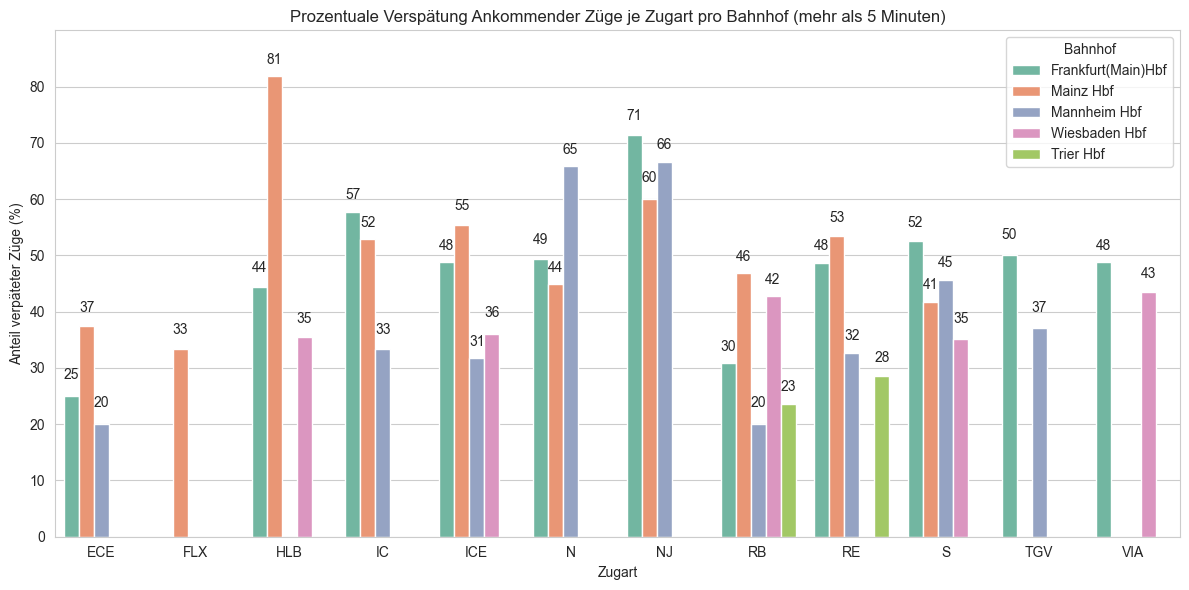

Banhöfe Frankfurt(Main)Hbf Mainz Hbf Mannheim Hbf Trier Hbf Wiesbaden Hbf
Zugart                                                                   
ECE                   25.0      37.5         20.0         -             -
FLX                      -     33.33            -         -             -
HLB                  44.37     81.81            -         -         35.54
IC                   57.69     52.94        33.33         -             -
ICE                  48.74     55.46        31.71         -         36.08
N                    49.29     44.96        65.88         -             -
NJ                   71.42      60.0        66.66         -             -
RB                   30.94     46.93         20.0     23.63         42.85
RE                   48.73     53.49        32.64     28.52             -
S                    52.63     41.66        45.55         -         35.18
TGV                   50.0         -        37.03         -             -
VIA                  48.78         -  

/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/2051431445.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(alter_char, neuer_char) if isinstance(x, str) else x)


In [24]:
# 3. arrival_percentage_delay_by_categorie_more_than_5.png
percentage_delay_data = calculate_percentage_delay_by_category_and_station_x(
    data=arrival_filtered_data,
    delay_threshold=5,  # Schwellenwert in Minuten
    categories=["IC", "ICE", "RB", "RE", "S", "TGV", "VIA", "HLB", "N", "NJ", "FLX", "ECE"],
    combine_all_categories=False
)
plot_bar_chart_by_category_and_station_x(
        data=percentage_delay_data,
        title='Prozentuale Verspätung Ankommender Züge je Zugart pro Bahnhof (mehr als 5 Minuten)',
        x_axis_label='Zugart',
        y_axis_label='Anteil verpäteter Züge (%)',
        fig_size_x=12,
        fig_size_y=6,
        int_value=True,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )
#create_csv_calculate_percentage_delay_by_category_and_station_x(percentage_delay_data, "X.csv")
reorder_percentage_delay_data = reorder_calculate_percentage_delay_by_category_and_station_x(percentage_delay_data, "-")
print(reorder_percentage_delay_data)
create_csv(reorder_percentage_delay_data, "out/01_Prozentuale Verspätung Ankommender Züge je Zugart pro Bahnhof.csv")
ersetze_char_in_csv("out/01_Prozentuale Verspätung Ankommender Züge je Zugart pro Bahnhof.csv", ".", ",")

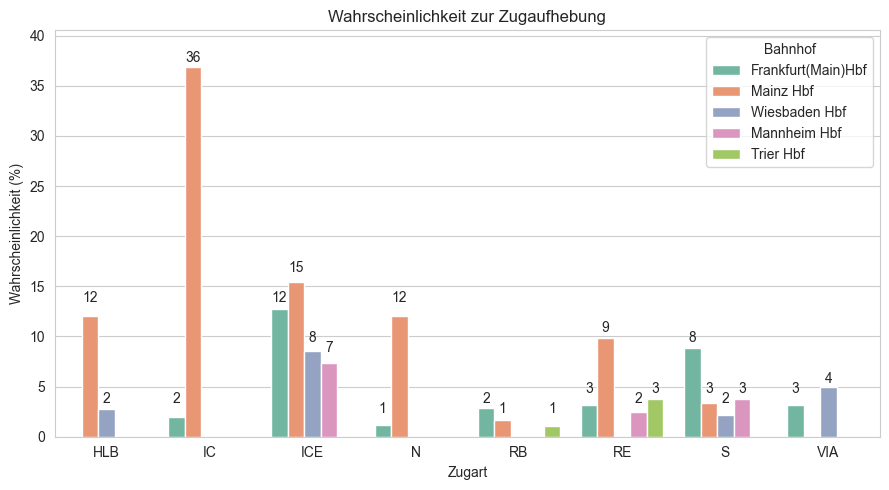

Banhöfe  Frankfurt(Main)Hbf Mainz Hbf Mannheim Hbf Trier Hbf Wiesbaden Hbf
Zugart                                                                    
HLB                    0.00      12.0            -         -          2.73
IC                     2.00     36.84          0.0         -             -
ICE                   12.75     15.46         7.31         -          8.53
N                      1.16     12.08          0.0         -             -
RB                     2.84      1.68          0.0      1.03           0.0
RE                     3.19       9.8         2.44       3.8             -
S                      8.82      3.34         3.76         -          2.14
VIA                    3.19         -            -         -          4.91


/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/2051431445.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(alter_char, neuer_char) if isinstance(x, str) else x)


In [25]:
# 3. Flex Ticket
percentage_delay_data = calculate_percentage_delay_by_category_and_station_x(
    data=depature_filtered_data,
    delay_threshold=25,  # Schwellenwert in Minuten
    categories=["IC", "ICE", "RB", "RE", "S", "VIA", "HLB", "N"],
    combine_all_categories=False
)
plot_bar_chart_by_category_and_station_x(
        data=percentage_delay_data,
        title='Wahrscheinlichkeit zur Zugaufhebung',
        x_axis_label='Zugart',
        y_axis_label='Wahrscheinlichkeit (%)',
        fig_size_x=9,
        fig_size_y=5,
        int_value=True,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )
reorder_percentage_delay_data = reorder_calculate_percentage_delay_by_category_and_station_x(percentage_delay_data, "-")
print(reorder_percentage_delay_data)
create_csv(reorder_percentage_delay_data, "out/02_Wahrscheinlichkeit zur Zugaufhebung.csv")
ersetze_char_in_csv("out/02_Wahrscheinlichkeit zur Zugaufhebung.csv", ".", ",")

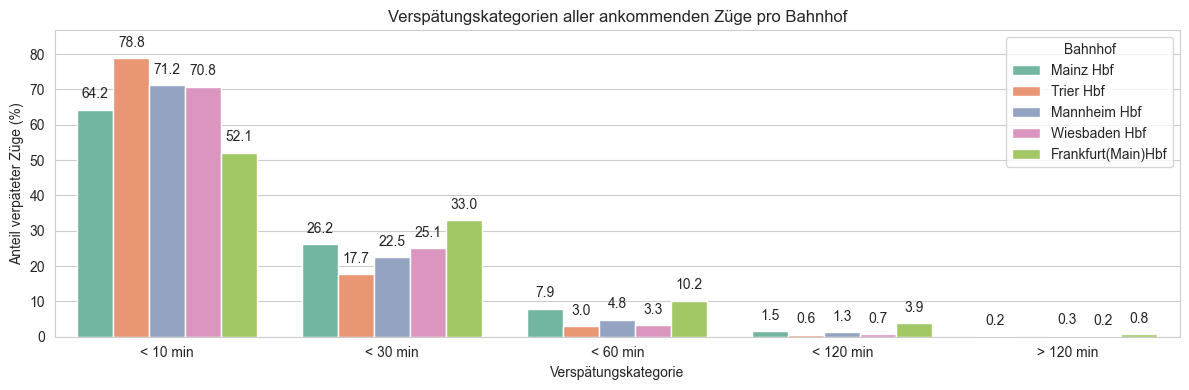

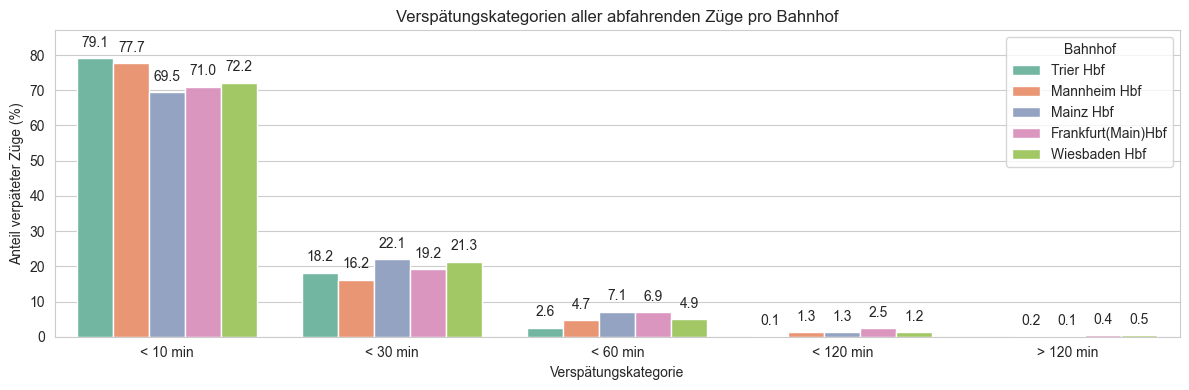

/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/562847941.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(index='Kategorie', columns='Banhöfe', values='Y', aggfunc='first')
/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/562847941.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(index='Kategorie', columns='Banhöfe', values='Y', aggfunc='first')
/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/2051431445.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(alter_char, neuer_cha

In [26]:
# 3. Verspätungsstatistik für eine Zugart berechnen
ar_train_delay_data = calculate_delay_statistics_by_train_type_and_station_x(
    data=arrival_filtered_data,
    train_type=["IC", "ICE", "RB", "RE", "S", "TGV"]     # Zugart (optional)
)
plot_bar_chart_by_category_and_station_x(
        data=ar_train_delay_data,
        title='Verspätungskategorien aller ankommenden Züge pro Bahnhof',
        x_axis_label='Verspätungskategorie',
        y_axis_label='Anteil verpäteter Züge (%)',
        fig_size_x=12,
        fig_size_y=4,
        int_value=False,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )

dp_train_delay_data = calculate_delay_statistics_by_train_type_and_station_x(
    data=depature_filtered_data,
    train_type=["IC", "ICE", "RB", "RE", "S", "TGV"]     # Zugart (optional)
)
plot_bar_chart_by_category_and_station_x(
        data=dp_train_delay_data,
        title='Verspätungskategorien aller abfahrenden Züge pro Bahnhof',
        x_axis_label='Verspätungskategorie',
        y_axis_label='Anteil verpäteter Züge (%)',
        fig_size_x=12,
        fig_size_y=4,
        int_value=False,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )
ar_train_delay_data = reorder_calculate_delay_statistics_by_train_type_and_station_x(ar_train_delay_data, "-")
dp_train_delay_data = reorder_calculate_delay_statistics_by_train_type_and_station_x(dp_train_delay_data, "-")
create_csv(ar_train_delay_data, "out/03_Verspätungskategorien aller ankommenden Züge pro Bahnhof.csv")
ersetze_char_in_csv("out/03_Verspätungskategorien aller ankommenden Züge pro Bahnhof.csv", ".", ",")
create_csv(dp_train_delay_data, "out/04_Verspätungskategorien aller abfahrenden Züge pro Bahnhof.csv")
ersetze_char_in_csv("out/04_Verspätungskategorien aller abfahrenden Züge pro Bahnhof.csv", ".", ",")

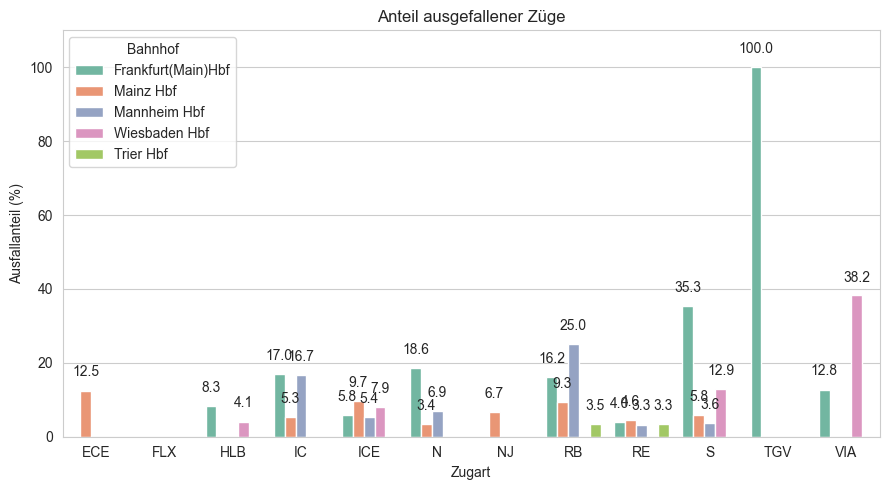

/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/2051431445.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(alter_char, neuer_char) if isinstance(x, str) else x)


In [27]:
# depature_cancellation_by_categorie
result = calculate_cancellations_by_train_type_and_station(
    data = depature_filtered_data,
    train_types=["IC", "ICE", "RB", "RE", "S", "TGV", "VIA", "HLB", "N", "NJ", "FLX", "ECE"],
    calculate_percentage=True
)
plot_bar_chart_by_category_and_station_x(
        data=result,
        title='Anteil ausgefallener Züge',
        x_axis_label='Zugart',
        y_axis_label='Ausfallanteil (%)',
        fig_size_x=9,
        fig_size_y=5,
        int_value=False,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )
result = reorder_calculate_percentage_delay_by_category_and_station_x(result, "-")
create_csv(result, "out/05_Anteil ausgefallener Züge (%).csv")
ersetze_char_in_csv("out/05_Anteil ausgefallener Züge (%).csv", ".", ",")

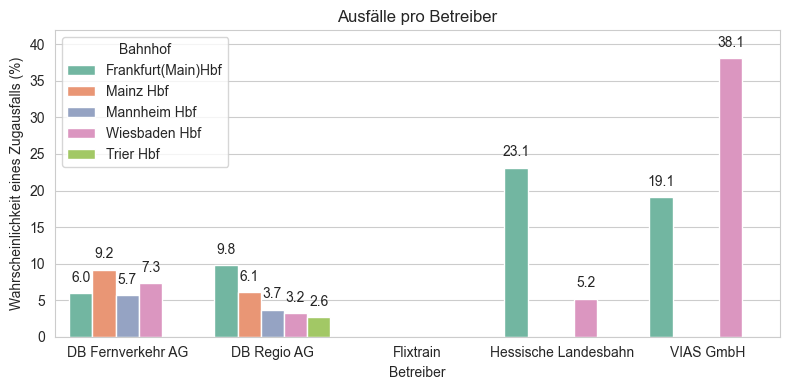

/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/2051431445.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(alter_char, neuer_char) if isinstance(x, str) else x)


In [28]:
# arrival data
cancellation_data_by_station = calculate_cancellations_by_operator_and_station(
    arrival_filtered_data,
    operators=["DB Fernverkehr AG", "DB Regio AG", "Flixtrain", "Hessische Landesbahn", "VIAS GmbH"],       # z. B. "DB Fernverkehr AG"
    calculate_percentage=True
)
plot_bar_chart_by_category_and_station_x(
        data=cancellation_data_by_station,
        title='Ausfälle pro Betreiber',
        x_axis_label='Betreiber',
        y_axis_label='Wahrscheinlichkeit eines Zugausfalls (%)',
        fig_size_x=8,
        fig_size_y=4,
        int_value=False,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )
cancellation_data_by_station = reorder_calculate_cancellations_by_operator_and_station(cancellation_data_by_station, "-")
create_csv(cancellation_data_by_station, "out/06_Ausfälle pro Betreiber (%).csv")
ersetze_char_in_csv("out/06_Ausfälle pro Betreiber (%).csv", ".", ",")

In [29]:
cancellation_data_by_operator_and_week = calculate_cancellations_by_operator_and_week(
    data=arrival_filtered_data,
    operator=None,
    calculate_percentage=False
)

cancellation_data_by_week = calculate_cancellations_by_week(
    data=arrival_filtered_data,
    calculate_percentage=False
)


plot_data = None
# 4. Balkendiagramm erstellen
if plot_data is None:
    print("")
elif plot_data is not cancellation_data_by_week:
    plot_bar_chart_by_category_and_station_x(
        data=plot_data,
        title='Prozentuale Verspätung je Zugart pro Bahnhof (mehr als 5 Minuten)',
        x_axis_label='Zugart',
        y_axis_label='Anteil verpäteter Züge (%)',
        fig_size_x=12,
        fig_size_y=6,
        int_value=True,        # Bei Prozentualen Ausfällen muss es hier "False" sein
    )
elif plot_data is cancellation_data_by_week:
    plot_cancellations_by_week(
        data=plot_data,
        title='Ausfälle je Kalenderwoche',
        x_axis_label='Kalenderwoche',
        y_axis_label='Anzahl Ausfälle',
        fig_size_x=6,
        fig_size_y=5
    )

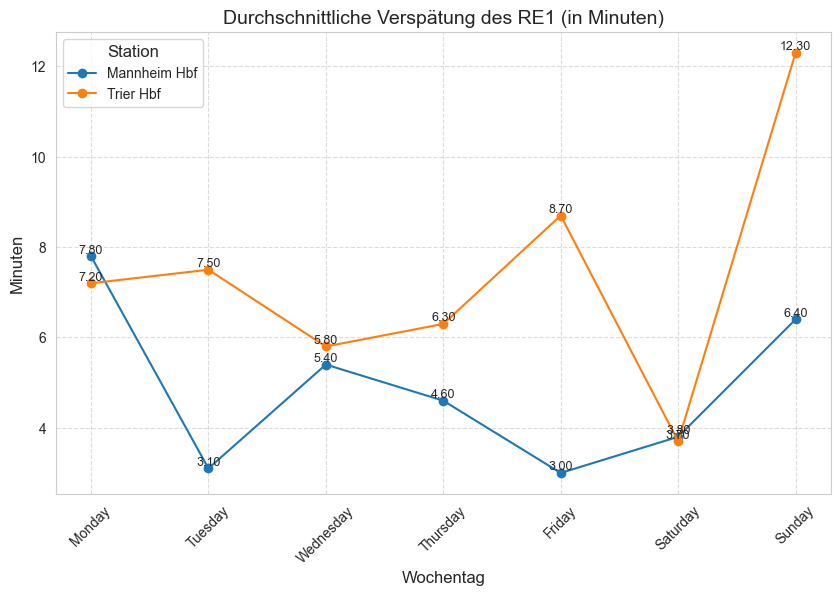

/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/2051431445.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(alter_char, neuer_char) if isinstance(x, str) else x)


In [30]:
# wichtig: Depature Züge
line = "RE1"

delay_by_line_and_day = calculate_delay_by_line_and_day(
    data=depature_filtered_data, 
    line=line, 
    output_type="min", 
    delay_threshold=0
)
plot_line_chart(delay_by_line_and_day, title="Durchschnittliche Verspätung des RE1 (in Minuten)", xlabel="Wochentag", ylabel="Minuten")
delay_by_line_and_day = reorder_calculate_delay_by_line_and_day(delay_by_line_and_day)
create_csv(delay_by_line_and_day, "out/07_Durchschnittliche Verspätung des RE1 (in Minuten).csv")
ersetze_char_in_csv("out/07_Durchschnittliche Verspätung des RE1 (in Minuten).csv", ".", ",")

In [31]:
line = "RE1"

cancelldation_by_line_and_day = calculate_cancellations_by_line_and_day(
    depature_filtered_data, 
    line, 
    "absolute",
    "day_of_week"
)
#plot_line_chart(cancelldation_by_line_and_day, title="Ausfälle des RE1", xlabel="Wochentag", ylabel="Anzahl")

/var/folders/43/l3hjvmnj5_7_dlqh7dw925s80000gn/T/ipykernel_14458/3770596868.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancelled_trains = cancelled_data.groupby(["station", group_by]).size().reset_index(name="cancelled_trains")


In [32]:


# Directory containing the CSV files
csv_directory = './out'  # Replace with your CSV directory path
output_excel_file = './out/output.xlsx'  # Name of the output Excel file

# Create a new Excel writer object
with pd.ExcelWriter(output_excel_file, engine='openpyxl') as writer:
    # Loop through all files in the directory
    for file_name in os.listdir(csv_directory):
        # Check if the file is a CSV
        if file_name.endswith('.csv'):
            file_path = os.path.join(csv_directory, file_name)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path, sep=';', decimal=',')

            # Use the file name (without extension) as the sheet name
            sheet_name = os.path.splitext(file_name[0:29])[0]

            # Write the DataFrame to a new sheet in the Excel file
            df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All CSV files have been combined into {output_excel_file}")


All CSV files have been combined into ./out/output.xlsx
